In [ ]:
import os
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import shutil
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, classification_report

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
# Image variables
im_width  = 100
im_height = 100

# Path Variables
data_path   = '../gtsrb-german-traffic-sign/versions/1/'

In [ ]:
# Load the training CSV file
df_train = pd.read_csv(os.path.join(data_path, 'Train.csv'), delimiter=',')

# Define the list of ClassIds not representing speed limit signs
not_speed_limit_classes = [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42]

# Extract only rows not corresponding to speed limit signs
not_speed_limit_df = df_train[df_train['ClassId'].isin(not_speed_limit_classes)].copy()

# Save the resulting DataFrame to a new CSV file
not_speed_limit_df.to_csv("whichSign.csv", index=False)

In [ ]:
# Load the testing CSV file
df_test = pd.read_csv(os.path.join(data_path, 'Test.csv'), delimiter=',')

# Extract only rows not corresponding to speed limit signs
speed_limit_df = df_train[df_train['ClassId'].isin(not_speed_limit_classes)].copy()

# Save the resulting DataFrame to a new CSV file
speed_limit_df.to_csv("whichSign_test.csv", index=False)

In [ ]:
# Load the CSV we just created
csv_path = "whichSign.csv"
df = pd.read_csv(csv_path)

# Create a new directory to store the sign images
dest_root = "whichSign_dataset"
os.makedirs(dest_root, exist_ok=True)

# Create subfolders for each class
for class_id in not_speed_limit_classes:
    os.makedirs(os.path.join(dest_root, str(class_id)), exist_ok=True)

# Iterate over each row in the CSV and copy images into their respective class folder
for _, row in df.iterrows():
    # Construct the source path
    src_path = os.path.join(data_path, row["Path"])
    
    # The target folder is determined by the ClassId
    target_folder = os.path.join(dest_root, str(row["ClassId"]))
    
    # Get the file name and define the destination path
    file_name = os.path.basename(src_path)
    dest_path = os.path.join(target_folder, file_name)
    
    # Copy the file
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        print(f"File not found: {src_path}")

In [ ]:
# Load the CSV we just created
csv_path = "whichSign_test.csv"
df = pd.read_csv(csv_path)

# Create a new directory to store the speed limit images
dest_root = "whichSign_dataset_test"
os.makedirs(dest_root, exist_ok=True)

# Create subfolders for each class
for class_id in not_speed_limit_classes:
    os.makedirs(os.path.join(dest_root, str(class_id)), exist_ok=True)

# Iterate over each row in the CSV and copy images into their respective class folder
for _, row in df.iterrows():
    # Construct the source path
    src_path = os.path.join(data_path, row["Path"])
    
    # The target folder is determined by the ClassId
    target_folder = os.path.join(dest_root, str(row["ClassId"]))
    
    # Get the file name and define the destination path
    file_name = os.path.basename(src_path)
    dest_path = os.path.join(target_folder, file_name)
    
    # Copy the file
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        print(f"File not found: {src_path}")

In [ ]:
batch_size = 32

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./whichSign_dataset/',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(im_height, im_width),
    batch_size=batch_size
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./whichSign_dataset/',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(im_height, im_width),
    batch_size=batch_size
)

# Adding a normalization layer to our model
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 26009 files belonging to 34 classes.
Using 20808 files for training.
Found 26009 files belonging to 34 classes.
Using 5201 files for validation.


In [ ]:
# Load the VGG16 base model without the classification head
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, 
                                         input_shape=(im_height, im_width, 3))
base_model.trainable = False  # Freeze the base model for initial training

# Custom classification model on top of the base model
model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(34, activation='softmax')  # 34 output neurons for multi-class classification
])

# Compile the model with sparse categorical crossentropy loss for integer labels
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Set up callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_whichSign_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 617s 943ms/step - accuracy: 0.6586 - loss: 1.2213 - val_accuracy: 0.8825 - val_loss: 0.3802
Epoch 2/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 574s 882ms/step - accuracy: 0.8891 - loss: 0.3744 - val_accuracy: 0.9210 - val_loss: 0.2619
Epoch 3/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 585s 899ms/step - accuracy: 0.9164 - loss: 0.2701 - val_accuracy: 0.9448 - val_loss: 0.1803
Epoch 4/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 605s 873ms/step - accuracy: 0.9315 - loss: 0.2263 - val_accuracy: 0.9444 - val_loss: 0.1784
Epoch 5/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 583s 896ms/step - accuracy: 0.9432 - loss: 0.1813 - val_accuracy: 0.9527 - val_loss: 0.1514
Epoch 6/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 574s 882ms/step - accuracy: 0.9449 - loss: 0.1666 - val_accuracy: 0.9625 - val_loss: 0.1317
Epoch 7/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 588s 904ms/step - accuracy: 0.9479 - loss: 0.1624 - val_accuracy: 0.9648 - val_loss: 0.1177
Epoch 8/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 589s 905ms/step - accuracy: 0.9532 -

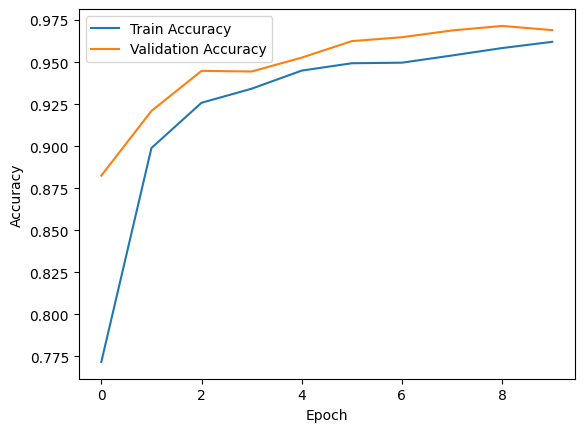

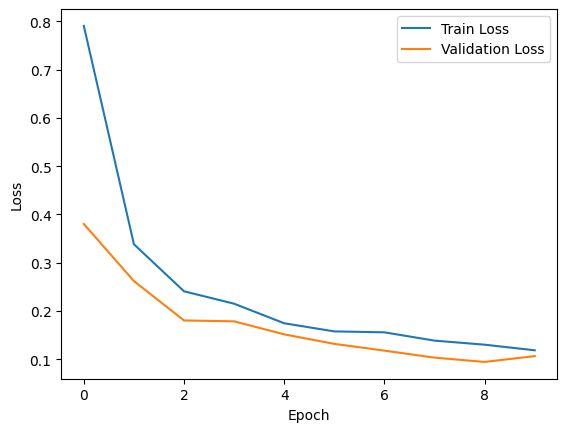

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./whichSign_dataset_test/',
    image_size=(im_height, im_width),
    batch_size=batch_size,
    shuffle=False  # Shuffle can be disabled for testing to maintain order
)

Found 26009 files belonging to 34 classes.


In [ ]:
model = tf.keras.models.load_model('../models/best_whichSign_model.keras')
batch_size=32

In [7]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

813/813 ━━━━━━━━━━━━━━━━━━━━ 659s 810ms/step - accuracy: 0.3370 - loss: 265.8654
Test Accuracy: 0.36


In [ ]:
# Mapping from class number to actual sign label (keys 9 to 42)
mapping = {
    9: "Interdiction de dépasser",
    10: "interdiction de dépasser pour poids lourd",
    11: "Voie prioritaire",
    12: "priorité à droite",
    13: "Laisser passer",
    14: "Stop",
    15: "Interdit au véhicules",
    16: "Interdit au poids lourd",
    17: "Sens interdit",
    18: "Attention",
    19: "Attention virage à gauche",
    20: "Attention virage à droite",
    21: "Succession de virage",
    22: "Dos d'ane",
    23: "Risque dérapage",
    24: "Voie rétrécie",
    25: "Attention travaux",
    26: "Feu tricolore",
    27: "Attention piéton",
    28: "Attention enfants",
    29: "Attention vélo",
    30: "Attention gel",
    31: "Attention animaux",
    32: "Fin d'interdiction",
    33: "Tourner à droite",
    34: "Tourner à gauche",
    35: "Continuer tout droit",
    36: "Tout Droit ou Droite",
    37: "Tout Droit ou Gauche",
    38: "Placer vous à droite",
    39: "Placer vous à gauche",
    40: "Rond point",
    41: "Fin Interdiction de dépasser",
    42: "Fin interdiction de dépasser poids lourds"
}

In [ ]:
# Gather true labels from the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Generate prediction probabilities using the model
y_pred_probs = model.predict(test_ds)

# Convert prediction probabilities to predicted class labels (using argmax)
y_pred = np.argmax(y_pred_probs, axis=1)

813/813 ━━━━━━━━━━━━━━━━━━━━ 544s 669ms/step


Confusion Matrix:
[[ 274    1    0 ...   65    0  190]
 [   5  281    0 ...   30    0    9]
 [   5    0 1038 ...  141    0    7]
 ...
 [   0    0    0 ...  116    0    0]
 [   1    0    2 ...  100    5    2]
 [   6    0    0 ...   39    0  600]]

Classification Report:
                                           precision    recall  f1-score   support

                 Interdiction de dépasser       0.79      0.14      0.23      2010
interdiction de dépasser pour poids lourd       0.42      0.21      0.28      1320
                         Voie prioritaire       0.96      0.49      0.65      2100
                        priorité à droite       0.99      0.46      0.62      2160
                           Laisser passer       0.46      0.93      0.62       780
                                     Stop       0.10      0.92      0.17       630
                    Interdit au véhicules       0.22      0.66      0.33       420
                  Interdit au poids lourd       0.83      0.67   

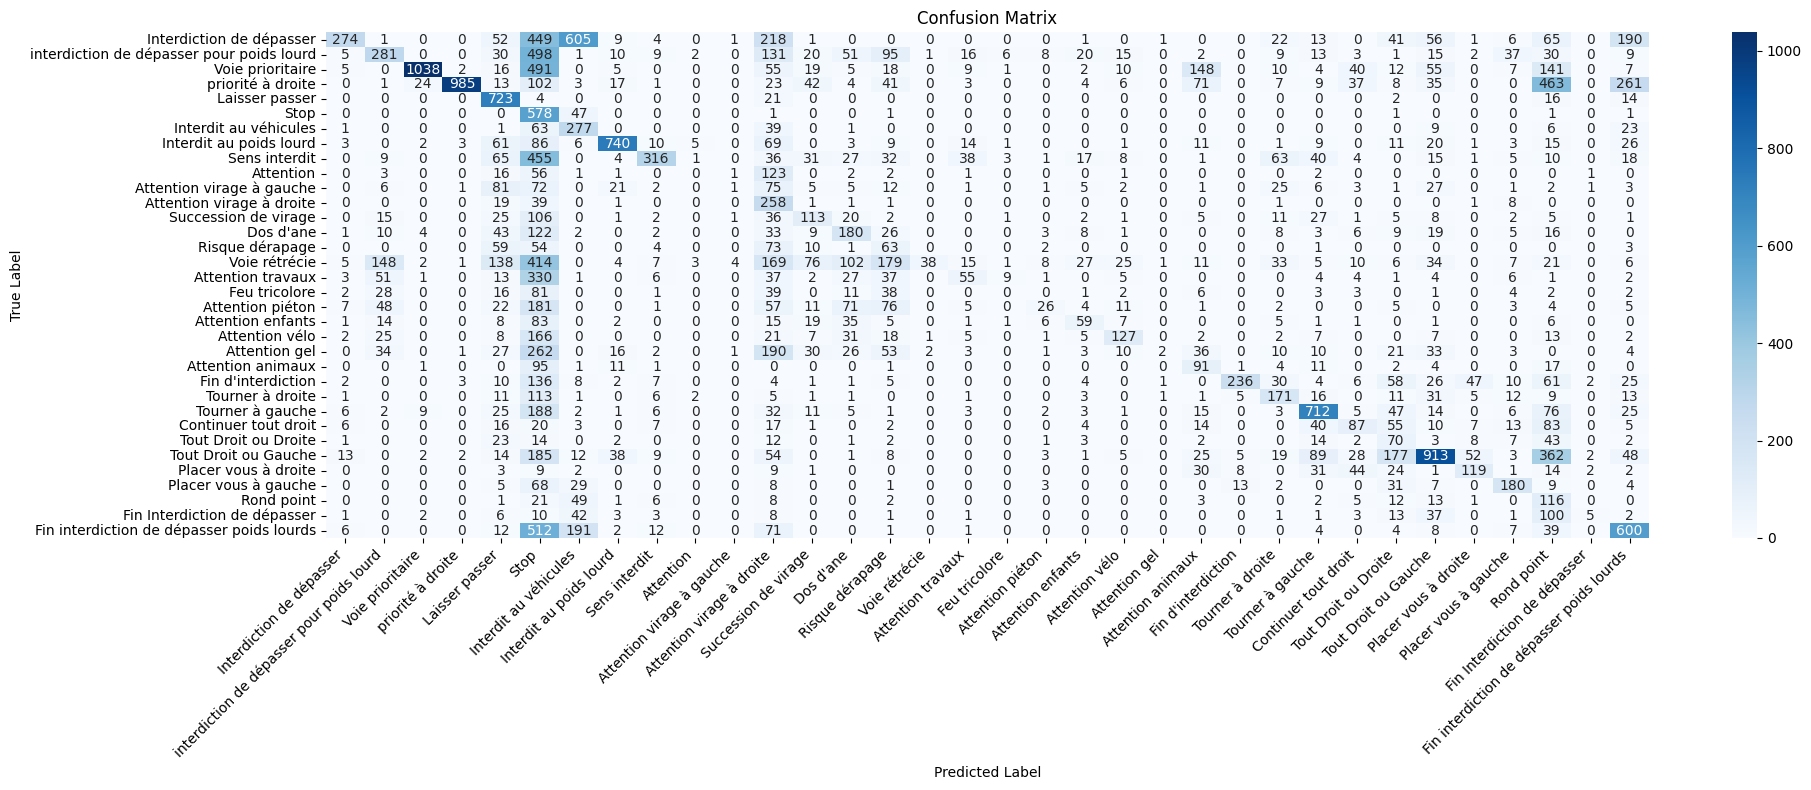

In [10]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Create target names using the mapping dictionary (ordered by key)
target_names = [mapping[k] for k in sorted(mapping.keys())]

# Print a classification report with the mapped class names
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Visualize the confusion matrix
plt.figure(figsize=(20, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Predicted sign: priorité à droite


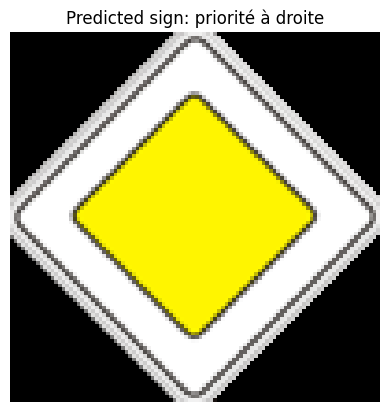

In [ ]:
# Path to image file
img_path = "../gtsrb-german-traffic-sign/versions/1/Meta/12.png" 

# Load the image and resize it
img = image.load_img(img_path, target_size=(im_height, im_width))
img_array = image.img_to_array(img)

# Normalize the image to [0, 1]
img_array = img_array / 255.0

# Add a batch dimension (model expects a batch of images)
img_batch = np.expand_dims(img_array, axis=0)

# Make prediction
prediction_probs = model.predict(img_batch)[0]
predicted_index = np.argmax(prediction_probs)

# Adjust the index to match mapping keys by adding 10
actual_class = predicted_index + 10
predicted_sign = mapping[actual_class]

print("Predicted sign:", predicted_sign)
result = f"Predicted sign: {predicted_sign}"

# Display the image with the prediction result
plt.imshow(img)
plt.title(result)
plt.axis("off")
plt.show()
